In [3]:
import torch

print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2060


In [8]:
import sys
sys.path.append("./src")

import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from src.bounding_box import BBoxModel
from src.image_transformations.coordinate_transforms import *
from src.bounding_box import BBoxModel
from src.keypoints_detection.keypoint_model import KPModel
import PIL
import cv2
from src.keypoints_detection.hourglass import hg
from scipy.spatial.transform import Rotation
import random
import pandas as pd
import json

# Test Keypoints on model

In [10]:
def make_numpy(kpts: list):
    np_kpts = []
    for i in range(10):
        kpt = [kpts[i*2], kpts[i*2+1]]
        np_kpts.append(kpt)
    return np.array(np_kpts)

def sort_kpts(kpts, pred_kpts):
    sort_order = []

    for i in range(10):
        distances = [np.linalg.norm(kpts[j, :2] - pred_kpts[i, :2]) for j in range(10)]
        min_dist = min(distances)
        min_idx = distances.index(min_dist)
        sort_order.append(min_idx)

    # make sure all keypoints are assigned 
    missing = [i for i in range(10) if i not in sort_order]
    if len(missing) != 0:
        return None
    
    sorted_kpts = []
    for i in sort_order:
        sorted_kpts.append(kpts[i, :2])
    return np.array(sorted_kpts)

def norm_pts(kpts, pred_kpts):
    norm = 0
    for i in range(10):
        norm += np.linalg.norm(kpts[i, :2] - pred_kpts[i, :2])
    return norm

In [12]:
# Change test based on data
test_path = "/media/david/Loser Drive/Keypoint_model"

KP_MODEL_PATH = "./models/keypoints_detection.pt"
kp_model = KPModel(KP_MODEL_PATH)

# with open(f"{test_path}/all_data.json", 'r') as f:
#     data = dict(json.load(f))
with open(f"{test_path}/NewData/accumulated_data/frame_data_test.json", 'r') as f:
    data = dict(json.load(f))

errors = []
confidences = []
num_rejected = 0
for i,file in enumerate(list(data.keys())):
    print(f"File {i+1} of {len(list(data.keys()))}", end="\r")
    kpts = data[file]["keypoints"]
    kpts = np.array(kpts)
    bbox = data[file]["bbox"]
    img_dir = data[file]["img_dir"]
    img = cv2.imread(f"{test_path}/{img_dir}/Images/{file}.png")
    pred_kpts = kp_model.predict(img, bbox)

    for i in range(10):

        errors.append(np.linalg.norm(kpts[i, :2]-pred_kpts[i, :2]))
        confidences.append(pred_kpts[i, 2])


    


In [23]:
test_path = "./data/RealWorldBboxData"

KP_MODEL_PATH = "./models/keypoints_detection.pt"
kp_model = KPModel(KP_MODEL_PATH)

with open(f"{test_path}/all_data.json", 'r') as f:
    data = dict(json.load(f))

errors = []
confidences = []
num_rejected = 0
for i,file in enumerate(list(data.keys())):
    print(f"File {i} of {len(list(data.keys()))}", end="\r")
    kpts = data[file]["keypoints"]
    kpts = make_numpy(kpts)
    bbox = data[file]["bbox"]
    img = cv2.imread(f"{test_path}/color/{file}.png")
    pred_kpts = kp_model.predict(img, bbox)


    kpts = sort_kpts(kpts, pred_kpts)
    if kpts is None:
        num_rejected += 1
        print(f"Rejecting {file}, rejected count = {num_rejected}")
        continue
    for i in range(10):
        errors.append(np.linalg.norm(kpts[i, :2] - pred_kpts[i, :2]))
        confidences.append(pred_kpts[i, 2])


Rejecting 1699122645801, rejected count = 1
Rejecting 1699122763755, rejected count = 2
Rejecting 1699122891376, rejected count = 3
Rejecting 1699126089806, rejected count = 4
Rejecting 1699126250829, rejected count = 5
Rejecting 1699126251333, rejected count = 6
Rejecting 1699126251918, rejected count = 7
Rejecting 1699126253171, rejected count = 8
Rejecting 1699126397548, rejected count = 9
Rejecting 1699126434344, rejected count = 10
Rejecting 1699126434412, rejected count = 11
Rejecting 1699126435146, rejected count = 12
Rejecting 1699122636825, rejected count = 13
Rejecting 1699122640603, rejected count = 14
Rejecting 1699122919835, rejected count = 15
Rejecting 1699123055211, rejected count = 16
Rejecting 1699123060222, rejected count = 17
Rejecting 1699123062409, rejected count = 18
Rejecting 1699126117141, rejected count = 19
Rejecting 1699126245544, rejected count = 20
Rejecting 1699126252070, rejected count = 21
Rejecting 1699126396411, rejected count = 22
Rejecting 169912640

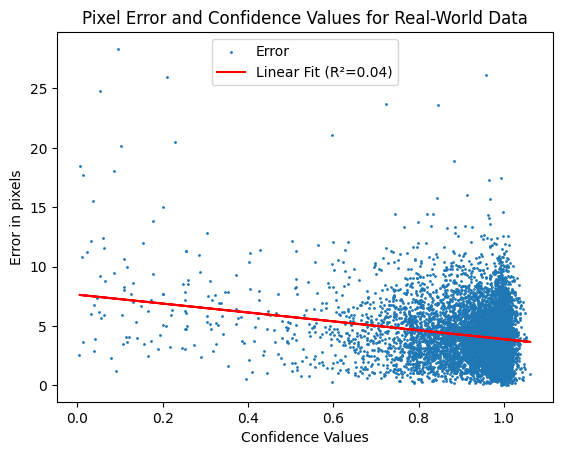

In [ ]:
# np.save("NewErrors.npy",errors)   
# np.save("NewConf.npy", confidences) 
errors = np.load("RealWorldErrors.npy")
confidences = np.load("RealWorldConf.npy")

from scipy.stats import linregress

nperrors = np.array(errors)
npconf = np.array(confidences)

slope, intercept, r_value, p_value, std_err = linregress(npconf, nperrors)
fit_line = slope * npconf + intercept

plt.scatter(npconf, nperrors, label='Error', s=1)
plt.plot(npconf, fit_line, color='red', label=f'Linear Fit (R²={r_value**2:.2f})')

# Set labels and title
plt.xlabel('Confidence Values')
plt.ylabel('Error in pixels')
plt.title('Pixel Error and Confidence Values for Real-World Data')# Add a legend
plt.legend()
plt.show()

(array([1, 2]),
 [Text(1, 0, 'Real World Data'), Text(2, 0, 'Simulated Test Data')])

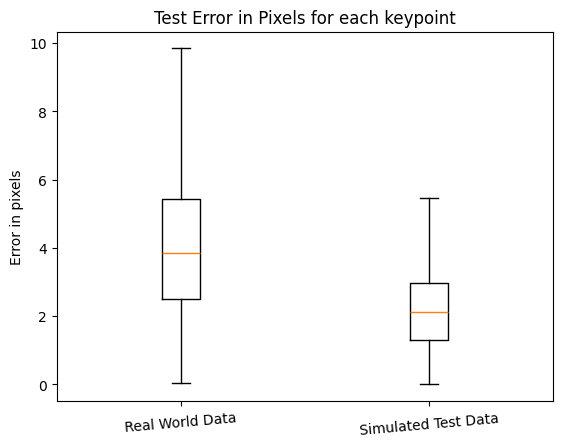

In [ ]:
rw = np.load("RealWorldErrors.npy")
nbd = np.load("NewBboxErrors.npy")
nd = np.load("NewErrors.npy")

plt.boxplot([rw, nd], showfliers=False, labels=["Real World Data", "Simulated Test Data"])

plt.title("Test Error in Pixels for each keypoint")
plt.ylabel("Error in pixels")
plt.xticks(rotation=5)


In [36]:

with open("data/RealWorldBboxData/all_data.json", 'r') as f:
    data = dict(json.load(f))

KP_MODEL_PATH = "./models/keypoints_detection.pt"
kp_model = KPModel(KP_MODEL_PATH)

# image = random.choice(list(data.keys()))
image = list(data.keys())[500]

image = "1699122645801"
kpts = data[image]["keypoints"]
bbox = data[image]["bbox"]
img = cv2.imread(f"data/RealWorldBboxData/color/{image}.png")

pred_kpts = kp_model.predict(img, bbox)
print(pred_kpts.astype(np.int64))
kpts = make_numpy(kpts)
kpts = sort_kpts(kpts, pred_kpts)

for i in range(10):
    x,y = kpts[i, :2]
    cv2.circle(img, (x,y), 5, (255,0,0), -1)
    x,y = [round(j) for j in pred_kpts[i, :2]]
    cv2.circle(img, (x,y), 5, (0,255,0), -1)


print(norm_pts(kpts, pred_kpts))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)


[[643 277   1]
 [646 233   0]
 [693 287   0]
 [700 236   0]
 [611 325   1]
 [684 325   0]
 [677 188   0]
 [592 192   0]
 [681 188   0]
 [715 249   0]]


TypeError: 'NoneType' object is not subscriptable